# **SVM model training and validation**

In [1]:
!pip install biopython
!pip install aaindex

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn.metrics as skl
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParamData
from aaindex import aaindex1
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import sys
sys.path.append('../shared_code')
import Data_analysis as da
import Von_Heijne_model as vh

# **Features extraction**



In [4]:
# Import the training set
training = pd.read_csv("../2_data_preparation/sets/train_with_seq.tsv", sep='\t')
training.head()

id             organism_name  kingdom  sequence_length  cleavage_site  \
0  Q99MA2         Rattus norvegicus  Metazoa              674           22.0   
1  P17948              Homo sapiens  Metazoa             1338           26.0   
2  P41271              Homo sapiens  Metazoa              181           16.0   
3  Q8I948  Acanthoscurria gomesiana  Metazoa              156           23.0   
4  Q92154         Coturnix japonica  Metazoa              620           17.0   

   validation_n  sp_type transmembrane  \
0             3        1           NaN   
1             1        1           NaN   
2             1        1           NaN   
3             4        1           NaN   
4             4        1           NaN   

                                            sequence  
0  MAQAYWQCYPWLVLLCACAWSYPGPESLGREDVRDCSTNPPRLPVT...  
1  MVSYWDTGVLLCALLSCLLLTGSSSGSKLKDPELSLKGTQHIMQAG...  
2  MMLRVLVGAVLPAMLLAAPPPINKLALFPDKSAWCEAKNITQIVGH...  
3  MAFRMKLVVCIVLLSTLAVMSSADVYKGGGGGRYGGGRYGGGGGYG...  
4  MELLVLTVLLMGTGCISAPWAAWMPPKMAALSGTCVQLPCRFDYPE...

In [5]:
benchmark = pd.read_csv("../2_data_preparation/sets/test_with_seq.tsv", sep='\t')
benchmark.head()

id                 organism_name        kingdom  sequence_length  \
0  A0A1S6EK92              Moringa oleifera  Viridiplantae               79   
1      P19801                  Homo sapiens        Metazoa              751   
2      P79263                    Sus scrofa        Metazoa              921   
3      P21814                    Ovis aries        Metazoa              429   
4      P29421  Oryza sativa subsp. japonica  Viridiplantae              200   

   cleavage_site  sp_type transmembrane  \
0           20.0        1           NaN   
1           19.0        1           NaN   
2           27.0        1           NaN   
3           25.0        1           NaN   
4           22.0        1           NaN   

                                            sequence  
0  MAKLSFLSLFLLCLVATATAQNCGRQAGNRACANGLCCSQYGFCGS...  
1  MPALGWAVAAILMLQTAMAEPSPGTLPRKAGVFSDLSNQELKAVHS...  
2  MKTLSPTGYGLLLVLPLLLAVLQSTTAHKNDINIYSLTVDSKVSSR...  
3  MSHRRMQLALSLVFILCGLFNSIFCEKQQHSQQHANLVLLKKISAF...  
4  MVSLRLPLILLSLLAISFSCSAAPPPVYDTEGHELSADGSYYVLPA...

In [11]:
# Assign a numeric index to each aminoacid
print(vh.index_aa)

AttributeError: module 'Von_Heijne_model' has no attribute 'index_aa'

In [20]:
def aa_composition(sequence, length: int, index_aa):
  ''' Calculate the aminoacid frequency of a sequence of a given length
  '''
  sequence = sequence[:length]
  freq = np.zeros((1, 20))
  for aa in sequence:
    if aa in index_aa.keys():
      freq[0,index_aa[aa]] += 1
  freq = np.round(freq/len(sequence), 3)
  return freq

# Calculate the aminoacid composition for each sequence of the dataframe and save it into a unique numpy matrix
aa_comp = np.vstack(training['sequence'].apply(aa_composition, args=(22, index_aa)))
aa_comp_test = np.vstack(benchmark['sequence'].apply(aa_composition, args=(22, index_aa)))

In [21]:
def hydrophobicity(sequence, window: int, length: int):
  ''' Calculates the hydrophobicity of each residue considering the context given by sliding window of adiacent aminoacids
  '''
  sequence = sequence[:length]
  seq = ProteinAnalysis(sequence)
  kd_pos = seq.protein_scale(ProtParamData.kd,window)
  d = int(window/2)
  sequence_with_padding = "X"*d + sequence + "X"*d
  seq_padding = ProteinAnalysis(sequence_with_padding)
  kd_pos_with_padding = seq_padding.protein_scale(ProtParamData.kd, window)
  warnings.filterwarnings('ignore')
  return kd_pos_with_padding

# Calculate the hydrophobicity of the first 40 residues for each sequence and save it into a unique matrix numpy
hydro = np.vstack(training['sequence'].apply(hydrophobicity, args=(5,40)))
hydro_test = np.vstack(benchmark['sequence'].apply(hydrophobicity, args=(5,40)))

In [22]:
feature_codes = {
    "net_charge": ("KLEP840101", 2),
    "hydrophilicity": ("HOPT810101", 5),
    "helix_propensity": ("CHAM830101",7),
    "flexibility": ("BHAR880101", 7),
    "isoelectric_point": ("ZIMJ680104", 2),
    "bulkiness": ("ZIMJ680102", 7)
}

def features(sequence, length: int, feature_code, window: int):
  ''' Creates an array of 3 values corresponding to mean, standard deviation,
      and maximum value of a given dictionary of features
  '''
  sequence = sequence[:length]
  seq = ProteinAnalysis(sequence)
  vals = aaindex1[feature_code].values
  val = seq.protein_scale(vals,window)
  mean = np.mean(val)
  std = np.std(val)
  max = np.max(val)
  return np.round([mean, std, max], 3)

feats = {}
for feature in feature_codes.keys():
  feats[feature] = np.vstack(training['sequence'].apply(features, args=(30, feature_codes[feature][0], feature_codes[feature][1])))

test_feat = {}
for feature in feature_codes.keys():
  test_feat[feature] = np.vstack(benchmark['sequence'].apply(features, args=(30, feature_codes[feature][0], feature_codes[feature][1])))

# Create the
np.savez('separate_features.npz', aa_comp = aa_comp, hydrophobicity = hydro, **feats)
np.savez('test_features.npz', aa_comp= aa_comp_test, hydrophobicity = hydro_test, **test_feat)

In [23]:
# Create a dictionary from the loaded features, handling multi-dimensional arrays
def npz_to_dataframe(npz_file):
  extracted_features = np.load(npz_file)
  data = {}
  for key in extracted_features.files:
      arr = extracted_features[key]
      if arr.ndim > 1:
          # If the array is multi-dimensional, create multiple columns
          for i in range(arr.shape[1]):
              data[f'{key}_{i+1}'] = arr[:, i]
      else:
          # If the array is 1-dimensional, use it directly
          data[key] = arr
  X = pd.DataFrame(data)
  return X, data

X, data = npz_to_dataframe("separate_features.npz")
X.head()

aa_comp_1  aa_comp_2  aa_comp_3  aa_comp_4  aa_comp_5  aa_comp_6  \
0      0.182      0.000        0.0      0.000      0.136      0.091   
1      0.045      0.000        0.0      0.045      0.091      0.000   
2      0.182      0.045        0.0      0.000      0.000      0.000   
3      0.091      0.045        0.0      0.000      0.045      0.000   
4      0.136      0.000        0.0      0.000      0.045      0.000   

   aa_comp_7  aa_comp_8  aa_comp_9  aa_comp_10  ...  helix_propensity_3  \
0      0.000      0.000        0.0       0.000  ...               1.333   
1      0.000      0.091        0.0       0.000  ...               1.354   
2      0.000      0.045        0.0       0.045  ...               1.223   
3      0.000      0.000        0.0       0.045  ...               1.209   
4      0.045      0.091        0.0       0.045  ...               1.159   

   flexibility_1  flexibility_2  flexibility_3  isoelectric_point_1  \
0          0.410          0.046          0.499                5.844   
1          0.427          0.043          0.512                5.919   
2          0.411          0.029          0.469                6.202   
3          0.410          0.027          0.488                6.171   
4          0.403          0.026          0.458                5.952   

   isoelectric_point_2  isoelectric_point_3  bulkiness_1  bulkiness_2  \
0                0.744                9.163       15.949        2.369   
1                0.862                8.487       14.830        2.777   
2                0.890                9.167       16.859        0.937   
3                1.044                9.000       16.351        2.594   
4                0.680                8.593       16.017        2.508   

   bulkiness_3  
0       20.414  
1       18.876  
2       18.960  
3       20.339  
4       20.644  

[5 rows x 78 columns]

In [24]:
T = npz_to_dataframe("test_features.npz")[0]

In [25]:
X["id"] = training["id"]
X["validation_n"] = training["validation_n"]
y = training["sp_type"]
X.head()


aa_comp_1  aa_comp_2  aa_comp_3  aa_comp_4  aa_comp_5  aa_comp_6  \
0      0.182      0.000        0.0      0.000      0.136      0.091   
1      0.045      0.000        0.0      0.045      0.091      0.000   
2      0.182      0.045        0.0      0.000      0.000      0.000   
3      0.091      0.045        0.0      0.000      0.045      0.000   
4      0.136      0.000        0.0      0.000      0.045      0.000   

   aa_comp_7  aa_comp_8  aa_comp_9  aa_comp_10  ...  flexibility_2  \
0      0.000      0.000        0.0       0.000  ...          0.046   
1      0.000      0.091        0.0       0.000  ...          0.043   
2      0.000      0.045        0.0       0.045  ...          0.029   
3      0.000      0.000        0.0       0.045  ...          0.027   
4      0.045      0.091        0.0       0.045  ...          0.026   

   flexibility_3  isoelectric_point_1  isoelectric_point_2  \
0          0.499                5.844                0.744   
1          0.512                5.919                0.862   
2          0.469                6.202                0.890   
3          0.488                6.171                1.044   
4          0.458                5.952                0.680   

   isoelectric_point_3  bulkiness_1  bulkiness_2  bulkiness_3      id  \
0                9.163       15.949        2.369       20.414  Q99MA2   
1                8.487       14.830        2.777       18.876  P17948   
2                9.167       16.859        0.937       18.960  P41271   
3                9.000       16.351        2.594       20.339  Q8I948   
4                8.593       16.017        2.508       20.644  Q92154   

   validation_n  
0             3  
1             1  
2             1  
3             4  
4             4  

[5 rows x 80 columns]

In [26]:
Y_T = benchmark["sp_type"]

# **Feature selection with RFE (Recursive Feature Elimination) and model training with SVM (Support Vector Machine)**

For each cross-validation fold made with different combination of train, validation and test sets:
*  Train an SVM baseline on all features.
*  Rank features by importance using a Random Forest.
*  Determine the optimal number of top features (k) using validation accuracy curves.
*  Retrain an SVM using only the top-k features.
*  Compare test accuracy with and without feature selection.
*  Save all datasets (.npz), plots, and results to allow reproducibility.

In [27]:
import sys
sys.path.append('../shared_code')  # aggiungi la cartella al path

import Von_Heijne_with_benchmark as vh

In [35]:
groups = vh.make_groups()
print(g)

1 2 3 4 5
2 3 4 5 1
3 4 5 1 2
4 5 1 2 3
5 1 2 3 4
{'Run_1': ((1, 2, 3), 4, 5), 'Run_2': ((2, 3, 4), 5, 1), 'Run_3': ((3, 4, 5), 1, 2), 'Run_4': ((4, 5, 1), 2, 3), 'Run_5': ((5, 1, 2), 3, 4)}


In [36]:
def svm_pipeline(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42))
    ])

def accuracy_on_subset(C, gamma, subset_features):
    # subset by feature names
    # Convert data keys to a NumPy array for use with np.where
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in subset_features]
    Xtr = X_train.iloc[:, idx]
    Xva = X_val.iloc[:, idx]
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)     # train on TRAIN only
    return pipe.score(Xva, y_val)  # accuracy on VALIDATION


In [37]:
def grid_search(C_grid, gamma_grid, X_train, Y_train, X_val, Y_val):
    best_score = -np.inf
    best_params = None

    for C in C_grid:
        for gamma in gamma_grid:
            pipe = svm_pipeline(C, gamma)
            pipe.fit(X_train, Y_train)
            val_acc = pipe.score(X_val, Y_val)
            if val_acc > best_score:
                best_score = val_acc
                best_params = {"C": C, "gamma": gamma}

    return best_score, best_params


=== RUN_1 ===
Train: (1, 2, 3), Val: 4, Test: 5
0.978 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0   hydrophilicity_1    0.088525
1  hydrophobicity_12    0.065966
2  hydrophobicity_10    0.057519
3  hydrophobicity_11    0.053042
4  hydrophobicity_13    0.051843
5        bulkiness_3    0.051351
6      flexibility_1    0.043066
7         aa_comp_11    0.042454
8   hydrophobicity_9    0.041239
9   hydrophobicity_8    0.035510


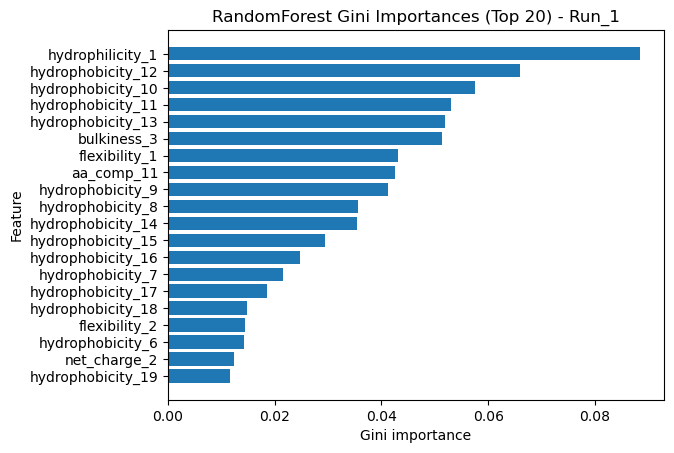

Best k on validation (using baseline best params): k=22, val_acc=0.975


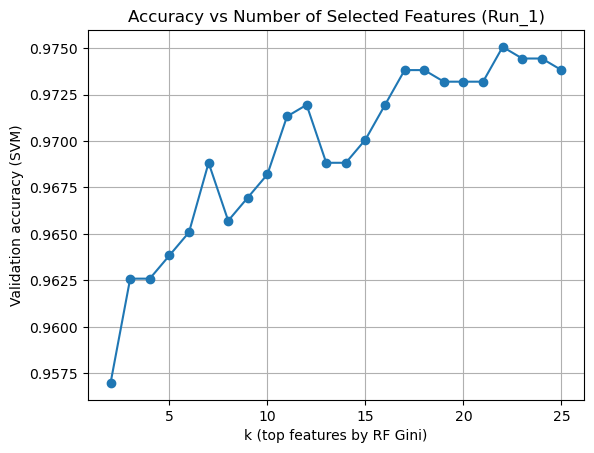


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.976
   → Found with parameters: C = 1.0, gamma = 0.1

Final test accuracy (using selected features): 0.970
Final test accuracy (using all features - baseline model): 0.976

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.849 | ACC = 0.970 | PPV = 0.847 | SEN = 0.886
Confusion Matrix:
 [[1402   28]
 [  20  155]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.881 | ACC = 0.976 | PPV = 0.854 | SEN = 0.937
Confusion Matrix:
 [[1402   28]
 [  11  164]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.849370  0.970093  0.846995  0.885714
1       All features  0.881254  0.975701  0.854167  0.937143

=== RUN_2 ===
Train: (2, 3, 4), Val: 5, Test: 1
0.977 with params {'C': 10.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0   hydrophilicity_1    0.082470
1  hydropho

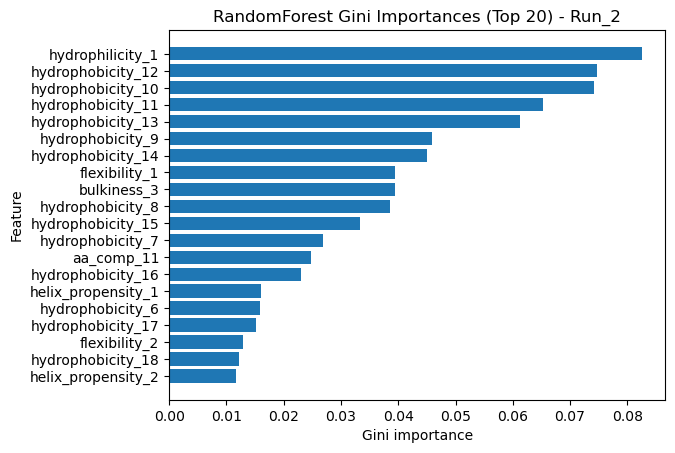

Best k on validation (using baseline best params): k=13, val_acc=0.966


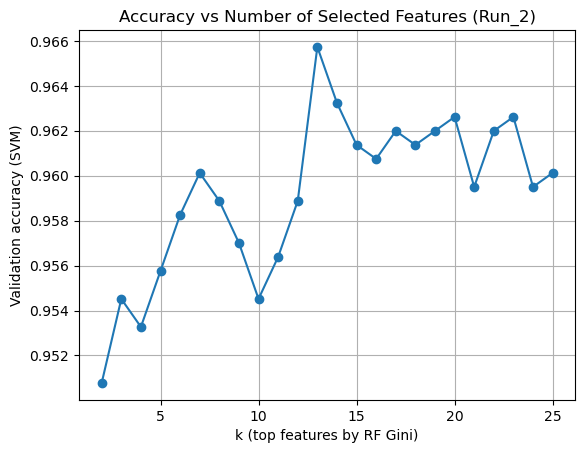


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.966
   → Found with parameters: C = 10.0, gamma = scale

Final test accuracy (using selected features): 0.959
Final test accuracy (using all features - baseline model): 0.971

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.789 | ACC = 0.959 | PPV = 0.808 | SEN = 0.817
Confusion Matrix:
 [[1396   34]
 [  32  143]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.852 | ACC = 0.971 | PPV = 0.873 | SEN = 0.863
Confusion Matrix:
 [[1408   22]
 [  24  151]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.789424  0.958879  0.807910  0.817143
1       All features  0.851762  0.971340  0.872832  0.862857

=== RUN_3 ===
Train: (3, 4, 5), Val: 1, Test: 2
0.973 with params {'C': 1.0, 'gamma': 0.01}
Top 10 features by Gini importance:
             feature  importance
0  hydrophobicity_11    0.082879
1  hydrophob

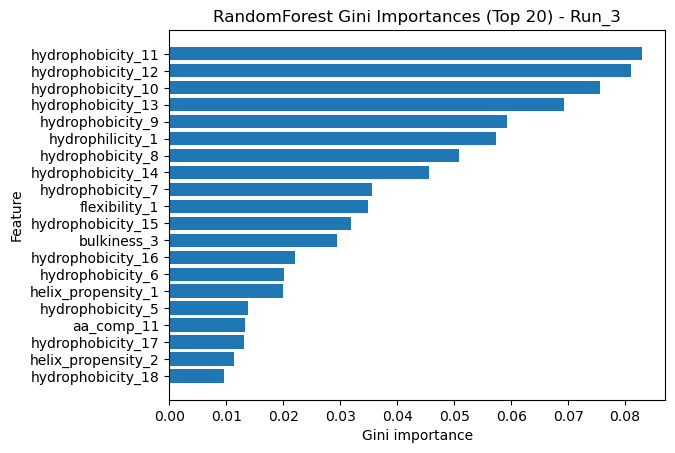

Best k on validation (using baseline best params): k=25, val_acc=0.967


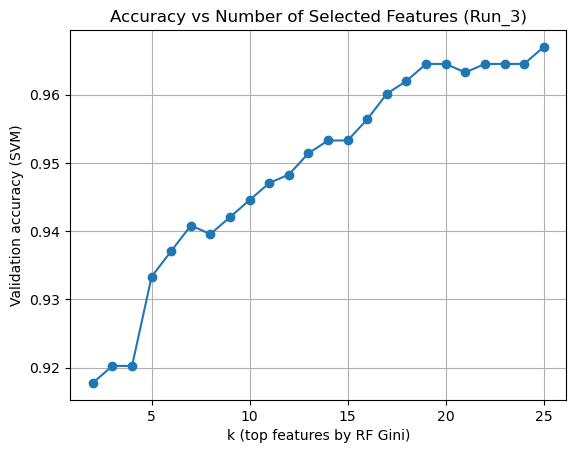


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.968
   → Found with parameters: C = 10.0, gamma = scale

Final test accuracy (using selected features): 0.968
Final test accuracy (using all features - baseline model): 0.968

 The model with feature selection performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.829 | ACC = 0.968 | PPV = 0.903 | SEN = 0.794
Confusion Matrix:
 [[1414   15]
 [  36  139]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.825 | ACC = 0.968 | PPV = 0.913 | SEN = 0.777
Confusion Matrix:
 [[1416   13]
 [  39  136]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.829449  0.968204  0.902597  0.794286
1       All features  0.824893  0.967581  0.912752  0.777143

=== RUN_4 ===
Train: (4, 5, 1), Val: 2, Test: 3
0.973 with params {'C': 10.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0  hydrophobicity_10    0.085224
1  hydrop

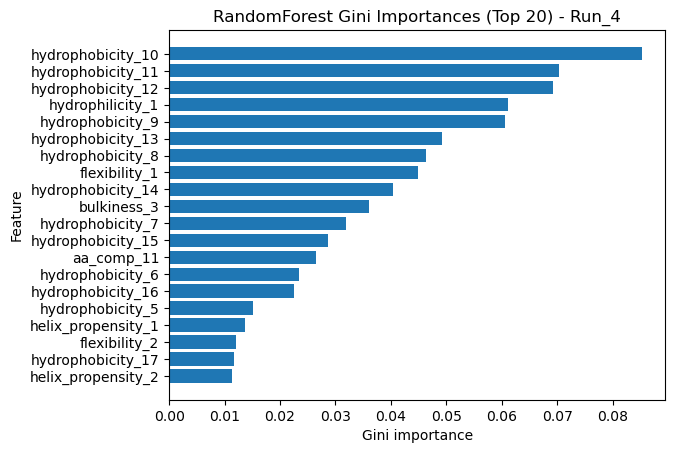

Best k on validation (using baseline best params): k=24, val_acc=0.969


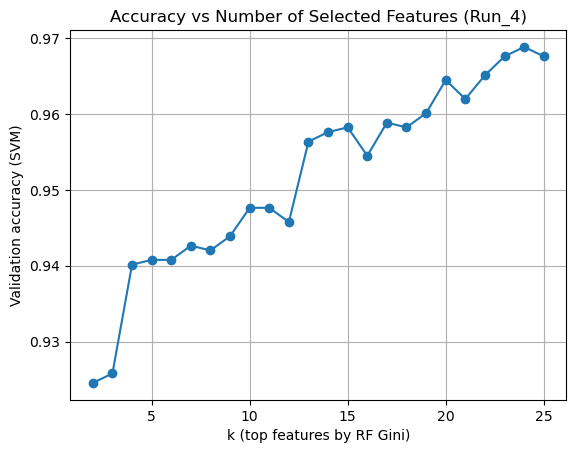


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.969
   → Found with parameters: C = 1.0, gamma = scale

Final test accuracy (using selected features): 0.973
Final test accuracy (using all features - baseline model): 0.973

 The model with selected features performs the same as the baseline.

=== SVM with FEATURE SELECTION ===
MCC = 0.860 | ACC = 0.973 | PPV = 0.888 | SEN = 0.862
Confusion Matrix:
 [[1410   19]
 [  24  150]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.858 | ACC = 0.973 | PPV = 0.902 | SEN = 0.845
Confusion Matrix:
 [[1413   16]
 [  27  147]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.859734  0.973175  0.887574  0.862069
1       All features  0.858004  0.973175  0.901840  0.844828

=== RUN_5 ===
Train: (5, 1, 2), Val: 3, Test: 4
0.976 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0   hydrophilicity_1    0.075967
1  hydrophobicity_

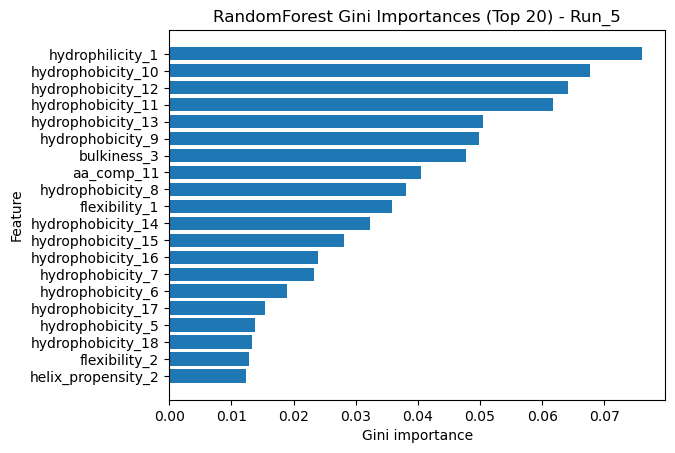

Best k on validation (using baseline best params): k=25, val_acc=0.973


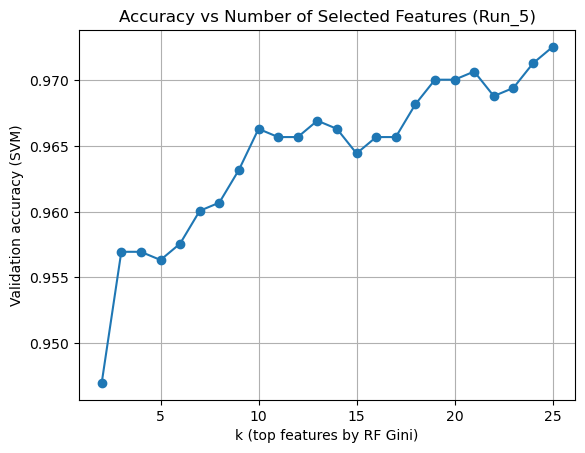


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.976
   → Found with parameters: C = 1.0, gamma = 0.1

Final test accuracy (using selected features): 0.974
Final test accuracy (using all features - baseline model): 0.978

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.869 | ACC = 0.974 | PPV = 0.881 | SEN = 0.886
Confusion Matrix:
 [[1408   21]
 [  20  155]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.886 | ACC = 0.978 | PPV = 0.912 | SEN = 0.886
Confusion Matrix:
 [[1414   15]
 [  20  155]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.868845  0.974439  0.880682  0.885714
1       All features  0.886446  0.978180  0.911765  0.885714


In [39]:
results = []
# Define search grids for SVM hyperparameters C and gamma.
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

all_metric_sel = []
all_metric_all = []

# Each iteration corresponds to one cross-validation fold.
# For each fold, we define TRAIN, VALIDATION, and TEST sets based on validation_n values.
for name, (train_idx, val_idx, test_idx) in groups.items():
    print(f"\n=== {name.upper()} ===")
    print(f"Train: {train_idx}, Val: {val_idx}, Test: {test_idx}")

    # Filter the main dataset (X and y) according to the fold indices.
    # Drop non-numerical or identifier columns such as 'id' and 'validation_n'.
    X_train = X[X["validation_n"].isin(train_idx)].drop(columns=["id", "validation_n"])
    X_val   = X[X["validation_n"].isin([val_idx])].drop(columns=["id", "validation_n"])
    X_test  = X[X["validation_n"].isin([test_idx])].drop(columns=["id", "validation_n"])

    y_train = y[training["validation_n"].isin(train_idx)]
    y_val   = y[training["validation_n"].isin([val_idx])]
    y_test  = y[training["validation_n"].isin([test_idx])]

    # Convert the DataFrames into NumPy arrays and save them in a single .npz file.
    # This stores all matrices for the current fold (train, validation, test) in one place.

    X_train_np = X_train.to_numpy()
    X_val_np = X_val.to_numpy()
    X_test_np = X_test.to_numpy()

    y_train_np = y_train.to_numpy()
    y_val_np = y_val.to_numpy()
    y_test_np = y_test.to_numpy()

    np.savez(
        f"cv_set_{name}.npz",
        X_train=X_train_np,
        X_val=X_val_np,
        X_test=X_test_np,
        y_train=y_train_np,
        y_val=y_val_np,
        y_test=y_test_np
    )

    # Perform a manual grid search over C and gamma values.
    # Evaluate each model on the VALIDATION set and store the best parameters.

    best_score_base, best_params_base = grid_search(
    C_grid, gamma_grid,
    X_train.to_numpy(), y_train.to_numpy(),
    X_val.to_numpy(), y_val.to_numpy())
    print( f"{best_score_base:.3f} with params {best_params_base}")


    # Train a Random Forest classifier on the training data.
    # Use the Gini importance to rank features by their predictive power.
    rf = RandomForestClassifier(n_estimators=400,random_state=42,n_jobs=-1)
    rf.fit(X_train, y_train)

    gini_imp = pd.Series(rf.feature_importances_, index=list(data.keys())).sort_values(ascending=False)
    gini_df = gini_imp.reset_index()
    gini_df.columns = ["feature", "importance"]
    print("Top 10 features by Gini importance:")
    print(gini_df.head(10))

    # Visualize the 20 most important features as determined by the Random Forest.
    # Save the figure for documentation of this fold.
    plt.figure()
    plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
    plt.xlabel("Gini importance")
    plt.ylabel("Feature")
    plt.title(f"RandomForest Gini Importances (Top 20) - {name}")
    plt.savefig(f"gini_importances_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Test multiple subsets of top-k features ranked by Gini importance.
    # For each subset size, evaluate the validation accuracy of the baseline SVM.
    ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
    curve = []

    for k in ks:
        subset = gini_df["feature"].head(k).tolist()
        acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
        curve.append(acc_k)

    best_k_idx = int(np.argmax(curve))
    best_k = ks[best_k_idx]
    print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

    # Visualize how validation accuracy changes with different numbers of features.
    # The best k will correspond to the peak of the curve.
    plt.figure()
    plt.plot(ks, curve, marker="o")
    plt.xlabel("k (top features by RF Gini)")
    plt.ylabel("Validation accuracy (SVM)")
    plt.title(f"Accuracy vs Number of Selected Features ({name})")
    plt.grid(True)
    plt.savefig(f"accuracy_vs_features_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()


    # Keep only the best_k features and re-run the grid search to find new optimal parameters.
    best_subset = gini_df["feature"].head(best_k).tolist()
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in best_subset]

    Xtr_sel = X_train.iloc[:, idx]
    Xva_sel = X_val.iloc[:, idx]
    Xte_sel = X_test.iloc[:, idx]

    best_score_sel, best_params_sel = grid_search(
    C_grid, gamma_grid,
    Xtr_sel.to_numpy(), y_train.to_numpy(),
    Xva_sel.to_numpy(), y_val.to_numpy())
    final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
    final_pipe.fit(Xtr_sel.to_numpy(), y_train.to_numpy())
    test_acc = final_pipe.score(Xte_sel.to_numpy(), y_test.to_numpy())

    # For comparison: test accuracy with all features using baseline best params
    baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
    baseline_pipe.fit(X_train.to_numpy(), y_train.to_numpy())
    test_acc_all = baseline_pipe.score(X_test.to_numpy(), y_test.to_numpy())


    print("\n--- RESULTS SUMMARY ---")
    print(f"Best validation accuracy (after feature selection): {best_score_sel:.3f}")
    print(f"   → Found with parameters: C = {best_params_sel['C']}, gamma = {best_params_sel['gamma']}")

    print(f"\nFinal test accuracy (using selected features): {test_acc:.3f}")
    print(f"Final test accuracy (using all features - baseline model): {test_acc_all:.3f}")

    if test_acc > test_acc_all:
      print("\n The model with feature selection performs slightly better on the test set.")
    elif test_acc == test_acc_all:
      print("\n The model with selected features performs the same as the baseline.")
    else:
      print("\n The baseline model (all features) performs slightly better on the test set.")


    #METRICS
    y_pred_sel = final_pipe.predict(Xte_sel)
    y_pred_all = baseline_pipe.predict(X_test)

    obs_test = y_test

    MCC_sel, ACC_sel, PPV_sel, SEN_sel, CONF_sel = vh.metrics(obs_test, y_pred_sel)
    all_metric_sel.append([MCC_sel, ACC_sel,  PPV_sel, SEN_sel])

    MCC_all, ACC_all, PPV_all, SEN_all, CONF_all = vh.metrics(obs_test, y_pred_all)
    all_metric_all.append([MCC_all, ACC_all, PPV_all, SEN_all])

    print("\n=== SVM with FEATURE SELECTION ===")
    print(f"MCC = {MCC_sel:.3f} | ACC = {ACC_sel:.3f} | PPV = {PPV_sel:.3f} | SEN = {SEN_sel:.3f}")
    print("Confusion Matrix:\n", CONF_sel)

    print("\n=== SVM with ALL FEATURES (BASELINE) ===")
    print(f"MCC = {MCC_all:.3f} | ACC = {ACC_all:.3f} | PPV = {PPV_all:.3f} | SEN = {SEN_all:.3f}")
    print("Confusion Matrix:\n", CONF_all)

    results = pd.DataFrame({
    'Model': ['Selected features', 'All features'],
    'MCC': [MCC_sel, MCC_all],
    'ACC': [ACC_sel, ACC_all],
    'PPV': [PPV_sel, PPV_all],
    'SEN': [SEN_sel, SEN_all]
    })

    print(results)

In [40]:
#msd for the metric with all the features
arr_all = np.array(all_metric_all)
mean_all = np.mean(arr_all, axis=0)
std_all = np.std(arr_all, axis=0)

#mean and st for the metrics with selected features
arr_sel = np.array(all_metric_sel)
mean_sel = np.mean(arr_sel, axis=0)
std_sel = np.std(arr_sel, axis=0)

print("\n=== FEATURE SELECTION ===")
for name, mean, se in zip(["MCC","ACC","PPV","SEN"], mean_sel, std_sel):
    print(f"{name} = {mean:.3f} ± {se:.3f}")

print("\n=== ALL FEATURES ===")
for name, mean, se in zip(["MCC","ACC","PPV","SEN"], mean_all, std_all):
    print(f"{name} = {mean:.3f} ± {se:.3f}")


=== FEATURE SELECTION ===
MCC = 0.839 ± 0.028
ACC = 0.969 ± 0.006
PPV = 0.865 ± 0.034
SEN = 0.849 ± 0.037

=== ALL FEATURES ===
MCC = 0.860 ± 0.022
ACC = 0.973 ± 0.004
PPV = 0.891 ± 0.023
SEN = 0.862 ± 0.052


# **Evaluation on the benchmarking set**

In [41]:
train_indexes = [1,2,3,4]
x_training = X[X['validation_n'].isin(train_indexes)].drop(columns=["id", "validation_n"])
y_training = training["sp_type"][training['validation_n'].isin(train_indexes)]
x_validation = X[X['validation_n']==5].drop(columns=["id", "validation_n"])
y_validation = training["sp_type"].loc[training['validation_n']==5]

In [42]:
best_score, best_params = grid_search(C_grid, gamma_grid, x_training.to_numpy(), y_training.to_numpy(),x_validation.to_numpy(), y_validation.to_numpy())
final_pipeline = svm_pipeline(best_params["C"], best_params["gamma"])
final_pipeline.fit(x_training.to_numpy(), y_training.to_numpy())
test_acc = final_pipeline.score(T.to_numpy(), Y_T.to_numpy())
print( f"{best_score:.3f} with params {best_params}")


0.978 with params {'C': 10.0, 'gamma': 'scale'}


In [43]:
test_metrics = []
y_predictions = final_pipeline.predict(T)

observed_test = Y_T

mcc, acc, ppv, sen, conf = vh.metrics(observed_test, y_predictions)
test_metrics.append([mcc, acc, ppv, sen])

print("\n=== SVM on BENCHMARKING SET ===")
print("Confusion Matrix:\n", conf)

res = pd.DataFrame({
'MCC': mcc,
'ACC': acc,
'PPV': ppv,
'SEN': sen
}, index=[0])

print(res)


=== SVM on BENCHMARKING SET ===
Confusion Matrix:
 [[1764   23]
 [  27  192]]
        MCC       ACC       PPV       SEN
0  0.870866  0.975075  0.893023  0.876712


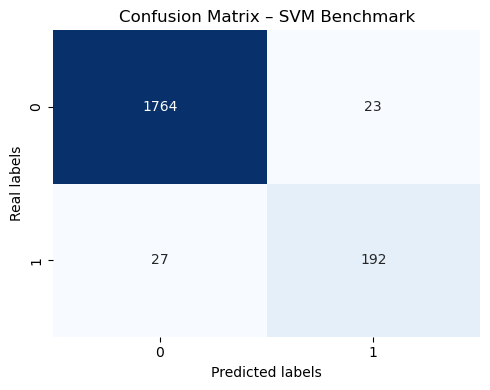

In [44]:
cm = np.array(conf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0,1],
            yticklabels= [0,1])

plt.title("Confusion Matrix – SVM Benchmark")
plt.xlabel("Predicted labels")
plt.ylabel("Real labels")
plt.tight_layout()
plt.show()

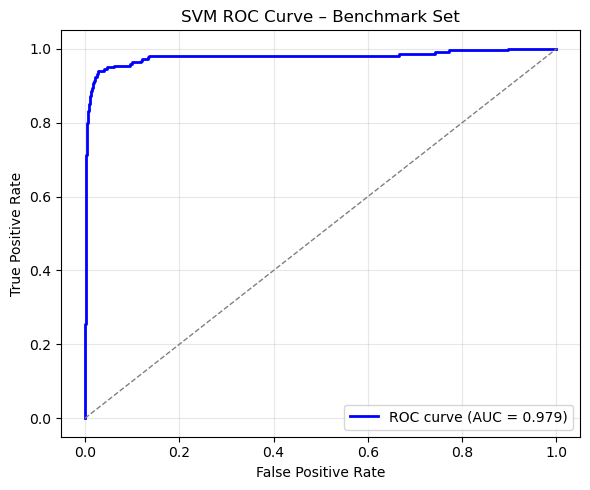

In [45]:
y_scores = final_pipeline.decision_function(T.to_numpy())

fpr, tpr, thresholds = roc_curve(Y_T, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve – Benchmark Set')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

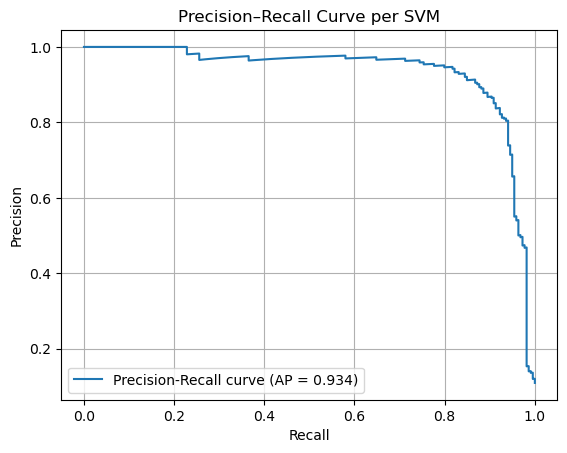

In [46]:
y_scores = final_pipeline.decision_function(T.to_numpy())
precision, recall, thresholds = precision_recall_curve(Y_T, y_scores)
avg_precision = average_precision_score(Y_T, y_scores)
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve per SVM')
plt.legend(loc='best')
plt.grid(True)
plt.show()
